# Lecture : Graph SVM

## Lab 01 : Standard/Linear SVM -- Exercise

### Xavier Bresson, Guoji Fu 


In [ ]:
# For Google Colaboratory
import sys, os
if 'google.colab' in sys.modules:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    path_to_file = '/content/gdrive/My Drive/CS5284_2025_codes/codes/04_Graph_SVM'
    print(path_to_file)
    # change current path to the folder containing "path_to_file"
    os.chdir(path_to_file)
    !pwd
    

In [1]:
# Load libraries
import numpy as np
import scipy.io
%matplotlib inline
#%matplotlib notebook 
from matplotlib import pyplot
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
from IPython.display import display, clear_output
import time
import sys; sys.path.insert(0, 'lib/')
from lib.utils import compute_purity
import warnings; warnings.filterwarnings("ignore")


# Linearly separable data points

In [2]:
# Dataset
mat = scipy.io.loadmat('datasets/data_linearSVM.mat')
Xtrain = mat['Xtrain']
Cgt_train = mat['Cgt_train'] - 1; Cgt_train = Cgt_train.squeeze()
l_train = mat['l'].squeeze()
n = Xtrain.shape[0]
d = Xtrain.shape[1]
nc = len(np.unique(Cgt_train))
print(n,d,nc)
Xtest = mat['Xtest']
Cgt_test = mat['Cgt_test'] - 1; Cgt_test = Cgt_test.squeeze()


40 2 2


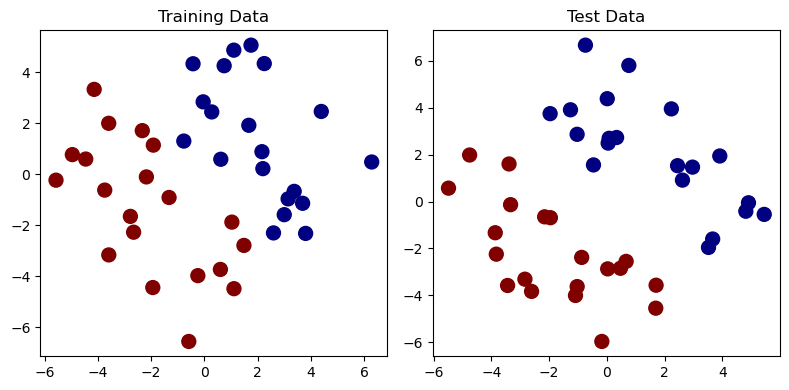

In [3]:
# Plot
plt.figure(figsize=(8,4))
p1 = plt.subplot(121)
size_vertex_plot = 100
plt.scatter(Xtrain[:,0], Xtrain[:,1], s=size_vertex_plot*np.ones(n), c=Cgt_train, color=pyplot.jet())
plt.title('Training Data')
p2 = plt.subplot(122)
size_vertex_plot = 100
plt.scatter(Xtest[:,0], Xtest[:,1], s=size_vertex_plot*np.ones(n), c=Cgt_test, color=pyplot.jet())
plt.title('Test Data')
plt.tight_layout()
plt.show()


### Question 1: Implement the linear SVM on linear separable data using the primal-dual iterative algorithm

*Hint:* Follow Page 18-20, Lecture 4 Slides

**Step 1:** Compute the Linear Kernel $Ker$ and $L, Q$ defined as
- $Ker= XX^\top$,
- $L = \text{diag}(l)$, 
- $Q = LKL$.
 
You may use function `np.diag()`, the transpose operator `.T`, and the matrix-matrix multiplication operator `.dot()`.
  

In [ ]:
# Compute linear kernel, L, Q

l = l_train

############################################################################
# Your code start
############################################################################

# @ is the matrix multiplication operator in Python 3.5+ (PEP 465),
#  equivalent to .dot() for 2D arrays.
# So Xtrain @ Xtrain.T is the same as Xtrain.dot(Xtrain.T).
# L @ Ker @ L is the same as L.dot(Ker.dot(L)).

Ker = Xtrain @ Xtrain.T
L = np.diag(l)
Q = L @ Ker @ L

# ans:
# Ker = Xtrain.dot(Xtrain.T)
# L = np.diag(l)
# Q = L.dot(Ker.dot(L))
############################################################################
# Your code end
############################################################################


**Step 2:** Initialize $\alpha^{k=0} = \beta^{k=0} = 0_n$.

You may use function `np.zeros()` for initializing a zero vector.


In [7]:
# Initialization
############################################################################
# Your code start
############################################################################

alpha = np.zeros(n)
beta = np.zeros(n)

############################################################################
# Your code end
############################################################################


**Step 3:** Choose the time steps $\tau_\alpha, \tau_\beta$ such that $\tau_\alpha\tau_\beta \leq \frac{1}{\|Q\| \cdot \|L\|}$.

Some feasible choices can be $\tau_\alpha = \frac{a}{\|Q\|}, \tau_\beta = \frac{b}{\|L\|}$, where $ab \leq 1$.

You may use `np.linalg.norm()` to compute the norm of a matrix.

Try to evaluate the performance of linear SVM with different choices of time steps.
  

In [8]:
# Time steps
############################################################################
# Your code start
############################################################################

tau_alpha = 10 / np.linalg.norm(Q, ord=2)  # 2-norm is the largest singular value
tau_beta = 0.1 / np.linalg.norm(L, ord=2)  # 2-norm is the largest singular value

############################################################################
# Your code end
############################################################################


**Step 4:** Project alpha to $[0, +\infty]$ during the update of alpha and beta with conjuguate gradient.


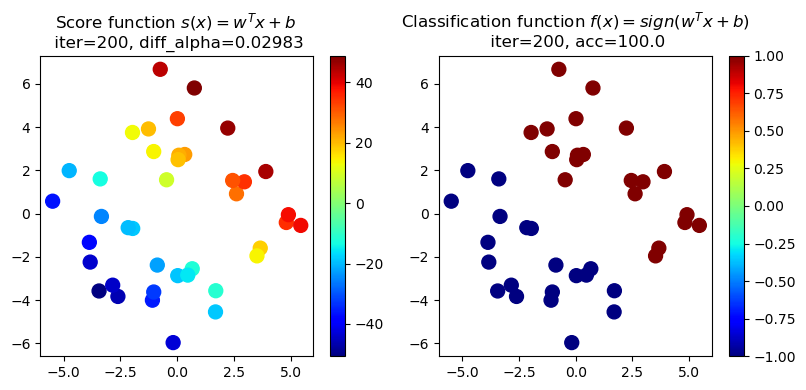

In [9]:
# Run Linear SVM

# Compute linear kernel, L, Q
Ker = Xtrain.dot(Xtrain.T)
l = l_train
L = np.diag(l)
Q = L.dot(Ker.dot(L))

# Time steps
tau_alpha = 10/ np.linalg.norm(Q,2)
tau_beta = 0.1/ np.linalg.norm(L,2)

# For conjuguate gradient
Acg = tau_alpha* Q + np.eye(n)

# Pre-compute J.K(Xtest) for test data
LKXtest = L.dot(Xtrain.dot(Xtest.T))

# Initialization
alpha_old = alpha

# Loop
k = 0
diff_alpha = 1e6
num_iter = 201
while (diff_alpha>1e-3) & (k<num_iter):
    
    # Update iteration
    k += 1
    
    # Update alpha
    # Approximate solution with conjuguate gradient
    b0 = alpha + tau_alpha - tau_alpha* l* beta
    
    # This line solves a linear system using the conjugate gradient (CG) method. 
    # It updates the variable alpha by approximately solving the equation Acg * alpha = b0. 
    # The CG method is efficient for large, sparse, symmetric positive-definite matrices.
    alpha, _ = scipy.sparse.linalg.cg(Acg, b0, x0=alpha, tol=1e-3, maxiter=50)   
    
    # Projection of alpha on [0,+infty]
    ############################################################################
    # Your code start
    ############################################################################

    # This line projects all negative values in alpha to zero. 
    # In other words, after the update, any element of alpha that is less than 0 is set to 0. 
    # This enforces the constraint that α ≥ 0 (as required by the SVM dual problem).
    alpha[alpha<0.0] = 0

    ############################################################################
    # Your code here
    ############################################################################

    # Update beta
    beta = beta + tau_beta* l.T.dot(alpha)
    
    # Stopping condition
    diff_alpha = np.linalg.norm(alpha-alpha_old)
    alpha_old = alpha
    
    # Plot
    if not(k%10) or (diff_alpha<1e-3):
           
        # Indicator function of support vectors
        idx = np.where( np.abs(alpha)>0.25* np.max(np.abs(alpha)) )
        Isv = np.zeros([n]); Isv[idx] = 1
        nb_sv = len(Isv.nonzero()[0])
        
        # Offset
        if nb_sv > 1:
            b = (Isv.T).dot( l - Ker.dot(L.dot(alpha)) )/ nb_sv
        else:
            b = 0
            
        # Continuous score function
        f_test = alpha.T.dot(LKXtest) + b 

        # Binary classification function
        C_test = np.sign(f_test) # decision function in {-1,1}
        accuracy_test = compute_purity(0.5*(1+C_test),Cgt_test,nc) # 0.5*(1+C_test) in {0,1}

        # Plot
        plt.figure(figsize=(8,4))
        p1 = plt.subplot(121)
        plt.scatter(Xtest[:,0], Xtest[:,1], s=size_vertex_plot*np.ones(n), c=f_test, color=pyplot.jet())
        plt.title('Score function $s(x)=w^Tx+b$ \n iter=' + str(k)+ ', diff_alpha=' + str(diff_alpha)[:7])
        plt.colorbar()
        p2 = plt.subplot(122)
        plt.scatter(Xtest[:,0], Xtest[:,1], s=size_vertex_plot*np.ones(n), c=C_test, color=pyplot.jet())
        plt.title('Classification function $f(x)=sign(w^Tx+b)$\n iter=' + str(k) + ', acc=' + str(accuracy_test)[:5])
        plt.tight_layout()
        plt.colorbar()
        plt.show()
        if k<num_iter-1:
            clear_output(wait=True)   
        

# Non-linearly separable data points

In [10]:
# Dataset
mat = scipy.io.loadmat('datasets/data_twomoons_softSVM.mat')
Xtrain = mat['Xtrain']
Cgt_train = mat['C_train_errors'] - 1; Cgt_train = Cgt_train.squeeze()
Cgt_train[:250] = 0; Cgt_train[250:] = 1
l_train = mat['l'].squeeze()
n = Xtrain.shape[0]
d = Xtrain.shape[1]
nc = len(np.unique(Cgt_train))
print(n,d,nc)
Xtest = mat['Xtest']
Cgt_test = mat['Cgt_test'] - 1; Cgt_test = Cgt_test.squeeze()


500 100 2


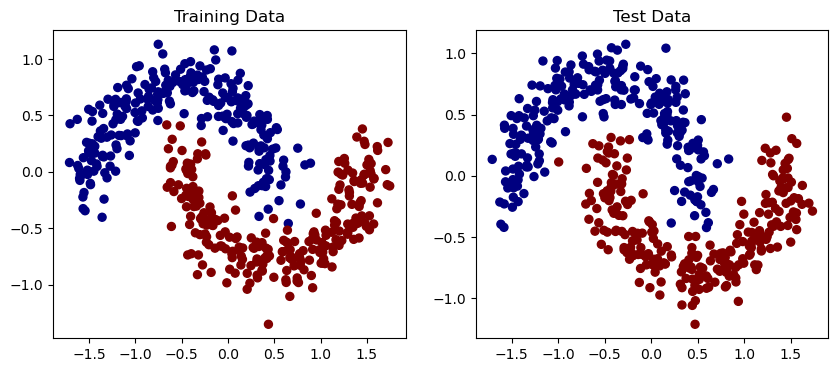

In [11]:
# Plot
plt.figure(figsize=(10,4))
p1 = plt.subplot(121)
size_vertex_plot = 33
plt.scatter(Xtrain[:,0], Xtrain[:,1], s=size_vertex_plot*np.ones(n), c=Cgt_train, color=pyplot.jet())
plt.title('Training Data')
p2 = plt.subplot(122)
size_vertex_plot = 33
plt.scatter(Xtest[:,0], Xtest[:,1], s=size_vertex_plot*np.ones(n), c=Cgt_test, color=pyplot.jet())
plt.title('Test Data')
#plt.tight_layout()
plt.show()


### Question 2: Compute linear kernel, L, Q, time steps, initialization and projection of alpha as for Question 1

Compare the results with the linearly separable case and determine which performs better. 

Answer: 

What strategy can be used to enhance the performance of SVM on non-linearly separable data?

Answer: 


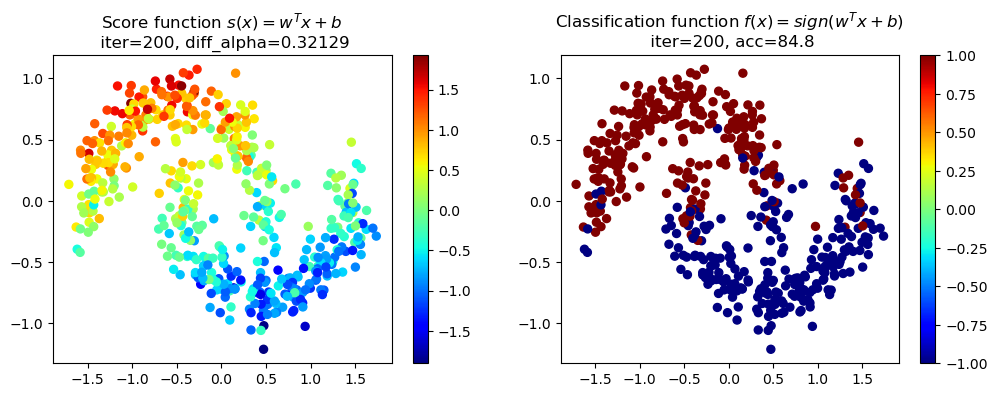

In [12]:
# Run Linear SVM

# Compute linear kernel, L, Q
Ker = Xtrain @ Xtrain.T
l = l_train
L = np.diag(l) # YOUR CODE HERE 
Q = L @ Ker @ L # YOUR CODE HERE 

# Time steps
tau_alpha = 10 / np.linalg.norm(Q, ord=2)  # 2-norm is the largest singular value
tau_beta = 0.1 / np.linalg.norm(L, ord=2)  # 2-norm is the largest singular value

# For conjuguate gradient
Acg = tau_alpha* Q + np.eye(n)

# Pre-compute J.K(Xtest) for test data
LKXtest = L.dot(Xtrain.dot(Xtest.T))

# Initialization
alpha = np.zeros(n) # YOUR CODE HERE 
beta = np.zeros(n)  # YOUR CODE HERE 
alpha_old = alpha

# Loop
k = 0
diff_alpha = 1e6
num_iter = 201
while (diff_alpha>1e-3) & (k<num_iter):
    
    # Update iteration
    k += 1
    
    # Update alpha
    # Approximate solution with conjuguate gradient
    b0 = alpha + tau_alpha - tau_alpha* l* beta
    alpha, _ = scipy.sparse.linalg.cg(Acg, b0, x0=alpha, tol=1e-3, maxiter=50)   

    # Projection on [0,+infty]
    alpha# YOUR CODE HERE  

    # Update beta
    beta = beta + tau_beta* l.T.dot(alpha)
    
    # Stopping condition
    diff_alpha = np.linalg.norm(alpha-alpha_old)
    alpha_old = alpha
    
    # Plot
    if not(k%10) or (diff_alpha<1e-3):
           
        # Indicator function of support vectors
        idx = np.where( np.abs(alpha)>0.25* np.max(np.abs(alpha)) )
        Isv = np.zeros([n]); Isv[idx] = 1
        nb_sv = len(Isv.nonzero()[0])
        
        # Offset
        if nb_sv > 1:
            b = (Isv.T).dot( l - Ker.dot(L.dot(alpha)) )/ nb_sv
        else:
            b = 0
            
        # Continuous score function
        f_test = alpha.T.dot(LKXtest) + b 

        # Binary classification function
        C_test = np.sign(f_test) # decision function in {-1,1}
        accuracy_test = compute_purity(0.5*(1+C_test),Cgt_test,nc) # 0.5*(1+C_test) in {0,1}

        # Plot
        size_vertex_plot = 33
        plt.figure(figsize=(12,4))
        p1 = plt.subplot(121)
        plt.scatter(Xtest[:,0], Xtest[:,1], s=size_vertex_plot*np.ones(n), c=f_test, color=pyplot.jet())
        plt.title('Score function $s(x)=w^Tx+b$ \n iter=' + str(k)+ ', diff_alpha=' + str(diff_alpha)[:7])
        plt.colorbar()
        p2 = plt.subplot(122)
        plt.scatter(Xtest[:,0], Xtest[:,1], s=size_vertex_plot*np.ones(n), c=C_test, color=pyplot.jet())
        plt.title('Classification function $f(x)=sign(w^Tx+b)$\n iter=' + str(k) + ', acc=' + str(accuracy_test)[:5])
        #plt.tight_layout()
        plt.colorbar()
        plt.show()
        if k<num_iter-1:
            clear_output(wait=True)   
        

# Lecture : Graph SVM

## Lab 02 : Soft-Margin SVM -- Exercise

### Xavier Bresson, Guoji Fu 


In [ ]:
# For Google Colaboratory
import sys, os
if 'google.colab' in sys.modules:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    path_to_file = '/content/gdrive/My Drive/CS5284_2025_codes/codes/04_Graph_SVM'
    print(path_to_file)
    # change current path to the folder containing "path_to_file"
    os.chdir(path_to_file)
    !pwd


In [1]:
# Load libraries
import numpy as np
import scipy.io
%matplotlib inline
#%matplotlib notebook 
from matplotlib import pyplot
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
from IPython.display import display, clear_output
import time
import sys; sys.path.insert(0, 'lib/')
from lib.utils import compute_purity
from lib.utils import compute_SVM
import warnings; warnings.filterwarnings("ignore")


# Linearly separable data points

In [2]:
# Data matrix X = linearly separable data points
mat = scipy.io.loadmat('datasets/data_softSVM.mat')
Xtrain = mat['Xtrain']
Cgt_train = mat['C_train_errors'] - 1; Cgt_train = Cgt_train.squeeze()
l_train = mat['l'].squeeze()
n = Xtrain.shape[0]
d = Xtrain.shape[1]
nc = len(np.unique(Cgt_train))
print(n,d,nc)
Xtest = mat['Xtest']
Cgt_test = mat['Cgt_test'] - 1; Cgt_test = Cgt_test.squeeze()


40 2 2


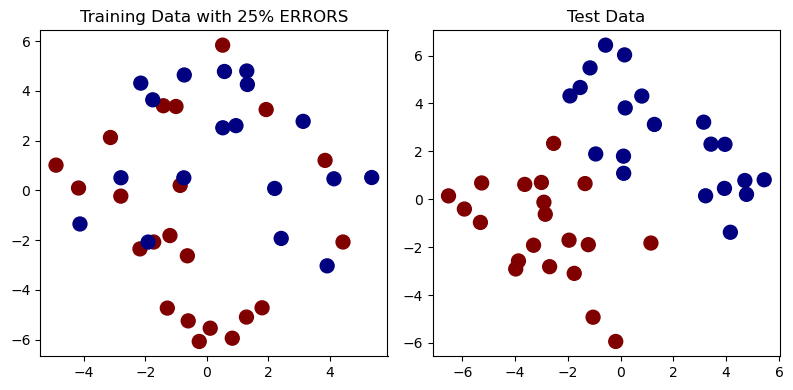

In [3]:
# Plot
plt.figure(figsize=(8,4))
p1 = plt.subplot(121)
size_vertex_plot = 100
plt.scatter(Xtrain[:,0], Xtrain[:,1], s=size_vertex_plot*np.ones(n), c=Cgt_train, color=pyplot.jet())
plt.title('Training Data with 25% ERRORS')
p2 = plt.subplot(122)
size_vertex_plot = 100
plt.scatter(Xtest[:,0], Xtest[:,1], s=size_vertex_plot*np.ones(n), c=Cgt_test, color=pyplot.jet())
plt.title('Test Data')
plt.tight_layout()
plt.show()


### Question 1: Evaluate the performance of soft-margin SVM on linearly separable data with different error parameters

How does the performance of a soft-margin SVM change on training and testing data as the error parameter increases?

Answer:  


In [6]:
# Error parameter
############################################################################
# Your code start
############################################################################

lamb = 0.01
lamb = 0.1

############################################################################
# Your code end
############################################################################


### Question 2: Project $\alpha$ to $[0, \lambda]$ during the update of alpha and beta with conjuguate gradient.


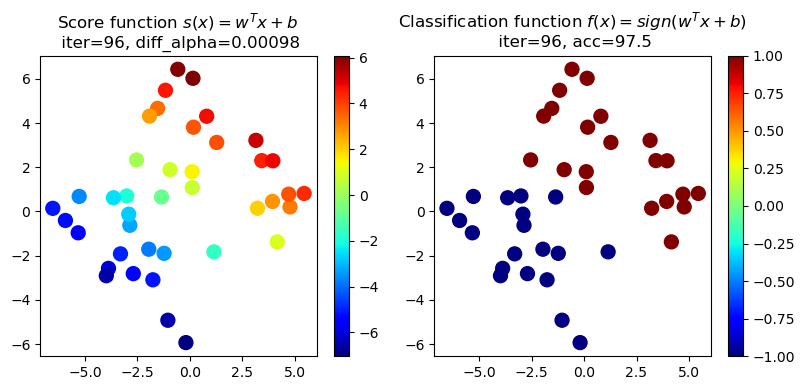

In [7]:
# Run soft-margin SVM

# Compute linear kernel, L, Q
Ker = Xtrain.dot(Xtrain.T)
l = l_train
L = np.diag(l)
Q = L.dot(Ker.dot(L))

# Time steps
tau_alpha = 10/ np.linalg.norm(Q,2)
tau_beta = 0.1/ np.linalg.norm(L,2)

# For conjuguate gradient
Acg = tau_alpha* Q + np.eye(n)

# Pre-compute J.K(Xtest) for test data
LKXtest = L.dot(Xtrain.dot(Xtest.T))

# Initialization
alpha = np.zeros([n])
beta = np.ones([n])
alpha_old = alpha

# Loop
k = 0
diff_alpha = 1e6
num_iter = 201
while (diff_alpha>1e-3) & (k<num_iter):
    
    # Update iteration
    k += 1
    
    # Update alpha
    # Approximate solution with conjuguate gradient
    b0 = alpha + tau_alpha - tau_alpha* l* beta
    alpha, _ = scipy.sparse.linalg.cg(Acg, b0, x0=alpha, tol=1e-3, maxiter=50)  
    
    # Projection of alpha on [0, \lambda]
    ############################################################################
    # Your code start
    ############################################################################

    alpha[alpha<0.0] = 0 # Projection on [0, +infty]
    alpha[alpha>lamb] = lamb # Projection on [-infty,lamb]

    ############################################################################
    # Your code end
    ############################################################################

    # Update beta
    beta = beta + tau_beta* l.T.dot(alpha)
    
    # Stopping condition
    diff_alpha = np.linalg.norm(alpha-alpha_old)
    alpha_old = alpha
    
    # Plot
    if not(k%10) or (diff_alpha<1e-3):
           
        # Indicator function of support vectors
        idx = np.where( np.abs(alpha)>0.25* np.max(np.abs(alpha)) )
        Isv = np.zeros([n]); Isv[idx] = 1
        nb_sv = len(Isv.nonzero()[0])
        
        # Offset
        if nb_sv > 1:
            b = (Isv.T).dot( l - Ker.dot(L.dot(alpha)) )/ nb_sv
        else:
            b = 0
            
        # Continuous score function
        f_test = alpha.T.dot(LKXtest) + b 

        # Binary classification function
        C_test = np.sign(f_test) # decision function in {-1,1}
        accuracy_test = compute_purity(0.5*(1+C_test),Cgt_test,nc) # 0.5*(1+C_test) in {0,1}

        # Plot
        plt.figure(figsize=(8,4))
        p1 = plt.subplot(121)
        plt.scatter(Xtest[:,0], Xtest[:,1], s=size_vertex_plot*np.ones(n), c=f_test, color=pyplot.jet())
        plt.title('Score function $s(x)=w^Tx+b$ \n iter=' + str(k)+ ', diff_alpha=' + str(diff_alpha)[:7])
        plt.colorbar()
        p2 = plt.subplot(122)
        plt.scatter(Xtest[:,0], Xtest[:,1], s=size_vertex_plot*np.ones(n), c=C_test, color=pyplot.jet())
        plt.title('Classification function $f(x)=sign(w^Tx+b)$\n iter=' + str(k) + ', acc=' + str(accuracy_test)[:5])
        plt.tight_layout()
        plt.colorbar()
        plt.show()
        if k<num_iter-1:
            clear_output(wait=True)   
        

# Non-linearly separable data points

In [8]:
# Dataset
mat = scipy.io.loadmat('datasets/data_twomoons_softSVM.mat')
Xtrain = mat['Xtrain']
Cgt_train = mat['C_train_errors'] - 1; Cgt_train = Cgt_train.squeeze()
l_train = mat['l'].squeeze()
n = Xtrain.shape[0]
d = Xtrain.shape[1]
nc = len(np.unique(Cgt_train))
print(n,d,nc)
Xtest = mat['Xtest']
Cgt_test = mat['Cgt_test'] - 1; Cgt_test = Cgt_test.squeeze()


500 100 2


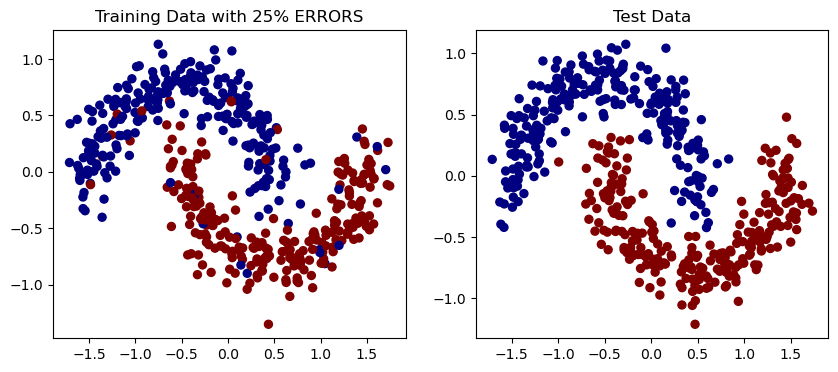

In [9]:
# Plot
plt.figure(figsize=(10,4))
p1 = plt.subplot(121)
size_vertex_plot = 33
plt.scatter(Xtrain[:,0], Xtrain[:,1], s=size_vertex_plot*np.ones(n), c=Cgt_train, color=pyplot.jet())
plt.title('Training Data with 25% ERRORS')
p2 = plt.subplot(122)
size_vertex_plot = 33
plt.scatter(Xtest[:,0], Xtest[:,1], s=size_vertex_plot*np.ones(n), c=Cgt_test, color=pyplot.jet())
plt.title('Test Data')
#plt.tight_layout()
plt.show()


### Question 3: Evaluate the performance of soft-margin SVM on non-linearly separable data with different error parameters

Compare the results with hard-margin Linear SVM, can significant improvements in soft-margin linear SVM over hard-margin linear SVM be achieved by tuning the error parameter on non-linearly separable data?

Answer: 
 

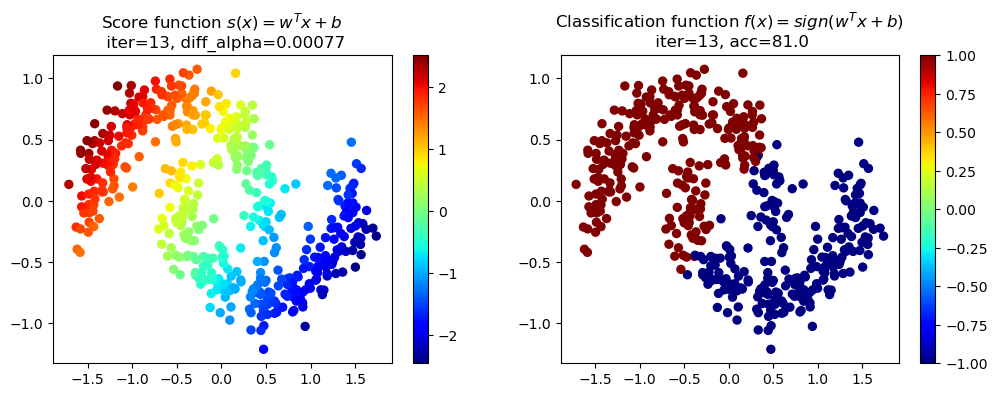

: 

In [ ]:
# Run soft-margin SVM

# Compute linear kernel, L, Q
Ker = Xtrain.dot(Xtrain.T)
l = l_train
L = np.diag(l)
Q = L.dot(Ker.dot(L))

# Time steps
tau_alpha = 10/ np.linalg.norm(Q,2)
tau_beta = 0.1/ np.linalg.norm(L,2)

# For conjuguate gradient
Acg = tau_alpha* Q + np.eye(n)

# Pre-compute J.K(Xtest) for test data
LKXtest = L.dot(Xtrain.dot(Xtest.T))

# Error parameter
############################################################################
# Your code start
############################################################################

lamb = 0.01

############################################################################
# Your code end
############################################################################

# Initialization
alpha = np.zeros([n])
beta = 0.0
alpha_old = alpha

# Loop
k = 0
diff_alpha = 1e6
num_iter = 201
while (diff_alpha>1e-3) & (k<num_iter):
    
    # Update iteration
    k += 1
    
    # Update alpha
    # Approximate solution with conjuguate gradient
    b0 = alpha + tau_alpha - tau_alpha* l* beta
    alpha, _ = scipy.sparse.linalg.cg(Acg, b0, x0=alpha, tol=1e-3, maxiter=50)   
    alpha[alpha<0.0] = 0 # Projection on [0,+infty]
    alpha[alpha>lamb] = lamb # Projection on [-infty,lamb]

    # Update beta
    beta = beta + tau_beta* l.T.dot(alpha)
    
    # Stopping condition
    diff_alpha = np.linalg.norm(alpha-alpha_old)
    alpha_old = alpha
    
    # Plot
    if not(k%10) or (diff_alpha<1e-3):
           
        # Indicator function of support vectors
        idx = np.where( np.abs(alpha)>0.25* np.max(np.abs(alpha)) )
        Isv = np.zeros([n]); Isv[idx] = 1
        nb_sv = len(Isv.nonzero()[0])
        
        # Offset
        if nb_sv > 1:
            b = (Isv.T).dot( l - Ker.dot(L.dot(alpha)) )/ nb_sv
        else:
            b = 0
            
        # Continuous score function
        f_test = alpha.T.dot(LKXtest) + b 

        # Binary classification function
        C_test = np.sign(f_test) # decision function in {-1,1}
        accuracy_test = compute_purity(0.5*(1+C_test),Cgt_test,nc) # 0.5*(1+C_test) in {0,1}

        # Plot
        size_vertex_plot = 33
        plt.figure(figsize=(12,4))
        p1 = plt.subplot(121)
        plt.scatter(Xtest[:,0], Xtest[:,1], s=size_vertex_plot*np.ones(n), c=f_test, color=pyplot.jet())
        plt.title('Score function $s(x)=w^Tx+b$ \n iter=' + str(k)+ ', diff_alpha=' + str(diff_alpha)[:7])
        plt.colorbar()
        p2 = plt.subplot(122)
        plt.scatter(Xtest[:,0], Xtest[:,1], s=size_vertex_plot*np.ones(n), c=C_test, color=pyplot.jet())
        plt.title('Classification function $f(x)=sign(w^Tx+b)$\n iter=' + str(k) + ', acc=' + str(accuracy_test)[:5])
        #plt.tight_layout()
        plt.colorbar()
        plt.show()
        if k<num_iter-1:
            clear_output(wait=True)   
        

# Lecture : Graph SVM

## Lab 03 : Kernel/Non-Linear SVM -- Exercise

### Xavier Bresson, Guoji Fu 


In [ ]:
# For Google Colaboratory
import sys, os
if 'google.colab' in sys.modules:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    path_to_file = '/content/gdrive/My Drive/CS5284_2025_codes/codes/04_Graph_SVM'
    print(path_to_file)
    # change current path to the folder containing "path_to_file"
    os.chdir(path_to_file)
    !pwd


In [1]:
# Load libraries
import numpy as np
import scipy.io
%matplotlib inline
#%matplotlib notebook 
from matplotlib import pyplot
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
plt.rcParams.update({'figure.max_open_warning': 0})
import time
import sys; sys.path.insert(0, 'lib/')
from lib.utils import compute_purity
from lib.utils import compute_SVM
import warnings; warnings.filterwarnings("ignore")
import sklearn.metrics.pairwise


# Non-linearly separable data points

In [2]:
# Dataset
mat = scipy.io.loadmat('datasets/data_twomoons_kernelSVM.mat')
Xtrain = mat['Xtrain']
Cgt_train = mat['C_train_errors'] - 1; Cgt_train = Cgt_train.squeeze()
l_train = mat['l'].squeeze()
n = Xtrain.shape[0]
d = Xtrain.shape[1]
nc = len(np.unique(Cgt_train))
print(n,d,nc)
Xtest = mat['Xtest']
Cgt_test = mat['Cgt_test'] - 1; Cgt_test = Cgt_test.squeeze()


500 100 2


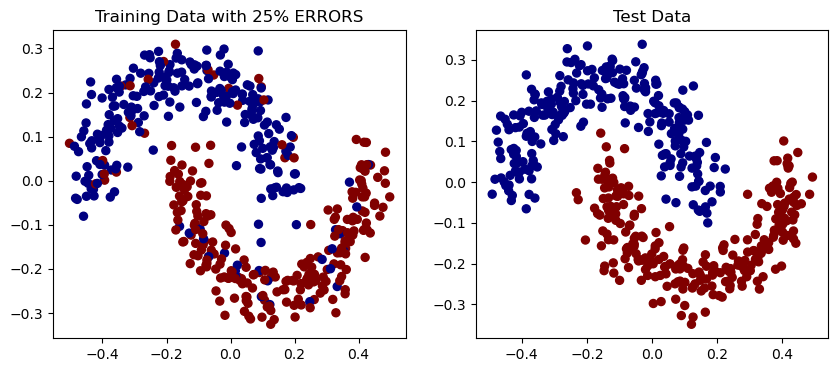

In [3]:
# Plot
plt.figure(figsize=(10,4))
p1 = plt.subplot(121)
size_vertex_plot = 33
plt.scatter(Xtrain[:,0], Xtrain[:,1], s=size_vertex_plot*np.ones(n), c=Cgt_train, color=pyplot.jet())
plt.title('Training Data with 25% ERRORS')
p2 = plt.subplot(122)
size_vertex_plot = 33
plt.scatter(Xtest[:,0], Xtest[:,1], s=size_vertex_plot*np.ones(n), c=Cgt_test, color=pyplot.jet())
plt.title('Test Data')
#plt.tight_layout()
plt.show()


# Run soft-margin SVM

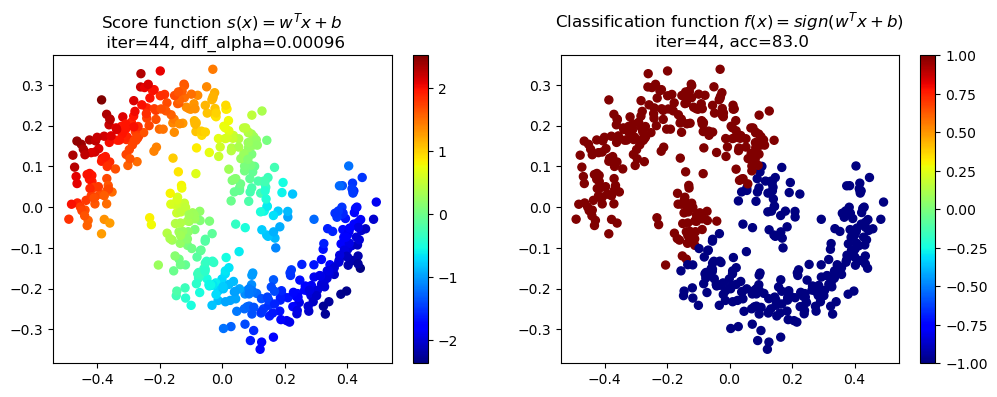

In [4]:
# Run soft-margin SVM

# Compute linear kernel, L, Q
Ker = Xtrain.dot(Xtrain.T)
l = l_train
L = np.diag(l)
Q = L.dot(Ker.dot(L))

# Time steps
tau_alpha = 10/ np.linalg.norm(Q,2)
tau_beta = 0.1/ np.linalg.norm(L,2)

# For conjuguate gradient
Acg = tau_alpha* Q + np.eye(n)

# Pre-compute J.K(Xtest) for test data
LKXtest = L.dot(Xtrain.dot(Xtest.T))

# Error parameter
lamb = 0.1 

# Initialization
alpha = np.zeros([n])
beta = np.zeros([n])
alpha_old = alpha

# Loop
k = 0
diff_alpha = 1e6
num_iter = 201
while (diff_alpha>1e-3) & (k<num_iter):
    
    # Update iteration
    k += 1
    
    # Update alpha
    # Approximate solution with conjuguate gradient
    b0 = alpha + tau_alpha - tau_alpha* l* beta
    alpha, _ = scipy.sparse.linalg.cg(Acg, b0, x0=alpha, tol=1e-3, maxiter=50)   
    alpha[alpha<0.0] = 0 # Projection on [0,+infty]
    alpha[alpha>lamb] = lamb # Projection on [-infty,lamb]

    # Update beta
    beta = beta + tau_beta* l.T.dot(alpha)
    
    # Stopping condition
    diff_alpha = np.linalg.norm(alpha-alpha_old)
    alpha_old = alpha
    
    # Plot
    if not(k%10) or (diff_alpha<1e-3):
           
        # Indicator function of support vectors
        idx = np.where( np.abs(alpha)>0.25* np.max(np.abs(alpha)) )
        Isv = np.zeros([n]); Isv[idx] = 1
        nb_sv = len(Isv.nonzero()[0])
        
        # Offset
        if nb_sv > 1:
            b = (Isv.T).dot( l - Ker.dot(L.dot(alpha)) )/ nb_sv
        else:
            b = 0
            
        # Continuous score function
        f_test = alpha.T.dot(LKXtest) + b 

        # Binary classification function
        C_test = np.sign(f_test) # decision function in {-1,1}
        accuracy_test = compute_purity(0.5*(1+C_test),Cgt_test,nc) # 0.5*(1+C_test) in {0,1}

        # Plot
        size_vertex_plot = 33
        plt.figure(figsize=(12,4))
        p1 = plt.subplot(121)
        plt.scatter(Xtest[:,0], Xtest[:,1], s=size_vertex_plot*np.ones(n), c=f_test, color=pyplot.jet())
        plt.title('Score function $s(x)=w^Tx+b$ \n iter=' + str(k)+ ', diff_alpha=' + str(diff_alpha)[:7])
        plt.colorbar()
        p2 = plt.subplot(122)
        plt.scatter(Xtest[:,0], Xtest[:,1], s=size_vertex_plot*np.ones(n), c=C_test, color=pyplot.jet())
        plt.title('Classification function $f(x)=sign(w^Tx+b)$\n iter=' + str(k) + ', acc=' + str(accuracy_test)[:5])
        #plt.tight_layout()
        plt.colorbar()
        plt.show()
        if k<num_iter-1:
            clear_output(wait=True)   
        


# Run kernel SVM

### Question 1: Calculate the distance of each pair data points and compute the Gaussian kernel

Gaussian kernel is defined as : $K_{i,j} = \exp({\frac{\|x_i - x_j\|^2}{2\sigma^2}})$ between a pair of data points $(i,j)$.
  
You may use function `sklearn.metrics.pairwise.pairwise_distances(X, Y, metric='euclidean', n_jobs=1)` to compute the euclidean distance between all vector pairs $\|x_i - x_j\|^2$.

Hint: You may consider $\sigma=0.5$.


In [ ]:
############################################################################
# Your code start
############################################################################

# The Euclidean distance of pair training data points
train_Ddist = sklearn.metrics.pairwise.pairwise_distances()

# The Euclidean distance of pair data points between training data and testing data
test_Ddist = sklearn.metrics.pairwise.pairwise_distances()

# Compute Gaussian kernel
sigma = 0.5
sigma2 = sigma**2
Ker = np.exp(-train_Ddist ** 2 / sigma2)
KXtest = np.exp(-test_Ddist ** 2 / sigma2)

############################################################################
# Your code end
############################################################################


### Question 2: Evaluate the performance of Kernel SVM on non-linearly separable data with different error parameters. 

Can kernel SVM outperform soft-margin linear SVM on non-linearly separable data?

Answer: 


In [7]:
############################################################################
# Your code start
############################################################################

# Error parameter
lamb = 3

############################################################################
# Your code end
############################################################################


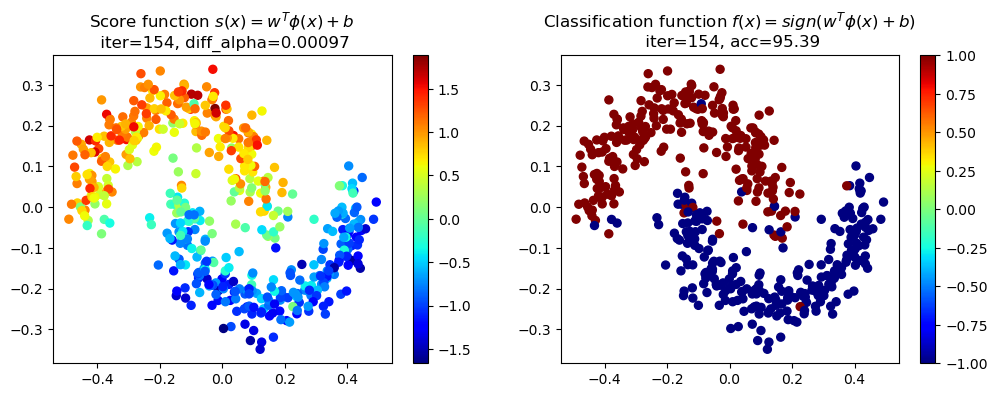

In [8]:
# Run kernel SVM

# Compute Gaussian kernel, L, Q
sigma = 0.5; sigma2 = sigma**2
Ddist = sklearn.metrics.pairwise.pairwise_distances(Xtrain, Xtrain, metric='euclidean', n_jobs=1)
Ker = np.exp(- Ddist**2 / sigma2)
Ddist = sklearn.metrics.pairwise.pairwise_distances(Xtrain, Xtest, metric='euclidean', n_jobs=1)
KXtest = np.exp(- Ddist**2 / sigma2)
l = l_train
L = np.diag(l)
Q = L.dot(Ker.dot(L))

# Time steps
tau_alpha = 10/ np.linalg.norm(Q,2)
tau_beta = 0.1/ np.linalg.norm(L,2)

# For conjuguate gradient
Acg = tau_alpha* Q + np.eye(n)

# Pre-compute J.K(Xtest) for test data
LKXtest = L.dot(KXtest)

# Initialization
alpha = np.zeros([n])
beta = np.zeros([n])
alpha_old = alpha

# Loop
k = 0
diff_alpha = 1e6
num_iter = 201
while (diff_alpha>1e-3) & (k<num_iter):
    
    # Update iteration
    k += 1
    
    # Update alpha
    # Approximate solution with conjuguate gradient
    b0 = alpha + tau_alpha - tau_alpha* l* beta
    alpha, _ = scipy.sparse.linalg.cg(Acg, b0, x0=alpha, tol=1e-3, maxiter=50)   
    alpha[alpha<0.0] = 0 # Projection on [0,+infty]
    alpha[alpha>lamb] = lamb # Projection on [-infty,lamb]

    # Update beta
    beta = beta + tau_beta* l.T.dot(alpha)
    
    # Stopping condition
    diff_alpha = np.linalg.norm(alpha-alpha_old)
    alpha_old = alpha
    
    # Plot
    if not(k%10) or (diff_alpha<1e-3):
           
        # Indicator function of support vectors
        idx = np.where( np.abs(alpha)>0.25* np.max(np.abs(alpha)) )
        Isv = np.zeros([n]); Isv[idx] = 1
        nb_sv = len(Isv.nonzero()[0])
        
        # Offset
        if nb_sv > 1:
            b = (Isv.T).dot( l - Ker.dot(L.dot(alpha)) )/ nb_sv
        else:
            b = 0
            
        # Continuous score function
        f_test = alpha.T.dot(LKXtest) + b 

        # Binary classification function
        C_test = np.sign(f_test) # decision function in {-1,1}
        accuracy_test = compute_purity(0.5*(1+C_test),Cgt_test,nc) # 0.5*(1+C_test) in {0,1}

        # Plot
        size_vertex_plot = 33
        plt.figure(figsize=(12,4))
        p1 = plt.subplot(121)
        plt.scatter(Xtest[:,0], Xtest[:,1], s=size_vertex_plot*np.ones(n), c=f_test, color=pyplot.jet())
        plt.title('Score function $s(x)=w^T\phi(x)+b$ \n iter=' + str(k)+ ', diff_alpha=' + str(diff_alpha)[:7])
        plt.colorbar()
        p2 = plt.subplot(122)
        plt.scatter(Xtest[:,0], Xtest[:,1], s=size_vertex_plot*np.ones(n), c=C_test, color=pyplot.jet())
        plt.title('Classification function $f(x)=sign(w^T\phi(x)+b)$\n iter=' + str(k) + ', acc=' + str(accuracy_test)[:5])
        #plt.tight_layout()
        plt.colorbar()
        plt.show()
        if k<num_iter-1:
            clear_output(wait=True)   
        


# Real-world graph of articles

In [9]:
# Dataset
mat = scipy.io.loadmat('datasets/data_20news_50labels.mat')
Xtrain = mat['Xtrain']
l_train = mat['l'].squeeze()
n = Xtrain.shape[0]
d = Xtrain.shape[1]
nc = len(np.unique(Cgt_train))
print(n,d,nc)
Xtest = mat['Xtest']
Cgt_test = mat['Cgt_test'] - 1; Cgt_test = Cgt_test.squeeze()


50 3684 2


# Run linear SVM

### Question 3: Run linear SVM on the real-world data 

Find the value `lamb` that maximizes the accuracy for the test set.


In [15]:
############################################################################
# Your code start
############################################################################

# Error parameter
lamb = 0.1

############################################################################
# Your code end
############################################################################


In [16]:
# Run linear SVM

# Compute Gaussian kernel, L, Q
Ker = sklearn.metrics.pairwise.pairwise_distances(Xtrain, Xtrain, metric='euclidean', n_jobs=1)
KXtest = sklearn.metrics.pairwise.pairwise_distances(Xtrain, Xtest, metric='euclidean', n_jobs=1)
l = l_train
L = np.diag(l)
Q = L.dot(Ker.dot(L))

# Time steps
tau_alpha = 10/ np.linalg.norm(Q,2)
tau_beta = 0.1/ np.linalg.norm(L,2)

# For conjuguate gradient
Acg = tau_alpha* Q + np.eye(n)

# Pre-compute J.K(Xtest) for test data
LKXtest = L.dot(KXtest)

# Initialization
alpha = np.zeros([n])
beta = np.zeros([n])
alpha_old = alpha

# Loop
k = 0
diff_alpha = 1e6
num_iter = 201
while (diff_alpha>1e-3) & (k<num_iter):
    
    # Update iteration
    k += 1
    
    # Update alpha
    # Approximate solution with conjuguate gradient
    b0 = alpha + tau_alpha - tau_alpha* l* beta
    alpha, _ = scipy.sparse.linalg.cg(Acg, b0, x0=alpha, tol=1e-3, maxiter=50)   
    alpha[alpha<0.0] = 0 # Projection on [0,+infty]
    alpha[alpha>lamb] = lamb # Projection on [-infty,lamb]

    # Update beta
    beta = beta + tau_beta* l.T.dot(alpha)
    
    # Stopping condition
    diff_alpha = np.linalg.norm(alpha-alpha_old)
    alpha_old = alpha
    
    # Plot
    if not(k%10) or (diff_alpha<1e-3):
           
        # Indicator function of support vectors
        idx = np.where( np.abs(alpha)>0.25* np.max(np.abs(alpha)) )
        Isv = np.zeros([n]); Isv[idx] = 1
        nb_sv = len(Isv.nonzero()[0])
        
        # Offset
        if nb_sv > 1:
            b = (Isv.T).dot( l - Ker.dot(L.dot(alpha)) )/ nb_sv
        else:
            b = 0
            
        # Continuous score function
        f_test = alpha.T.dot(LKXtest) + b 

        # Binary classification function
        C_test = np.sign(f_test) # decision function in {-1,1}
        accuracy_test = compute_purity(0.5*(1+C_test),Cgt_test,nc) # 0.5*(1+C_test) in {0,1}

        # Print
        print('Linear SVM, iter, diff_alpha, acc :',str(k),str(diff_alpha)[:7],str(accuracy_test)[:5])
        


Linear SVM, iter, diff_alpha, acc : 2 0.0 83.5


# Run kernel SVM

### Question 4: Evaluate the performance of kernel SVM on the real-world data 

Compare the results with soft-margin linear SVM. 

What are the implications of kernel SVM outperforming soft-margin linear SVM on real-world data?

Answer: 


In [21]:
############################################################################
# Your code start
############################################################################

# Error parameter
lamb = 2

############################################################################
# Your code end
############################################################################


In [ ]:
# Run kernel SVM

# Compute Gaussian kernel, L, Q
sigma = 0.5; sigma2 = sigma**2
Ddist = sklearn.metrics.pairwise.pairwise_distances(Xtrain, Xtrain, metric='euclidean', n_jobs=1)
Ker = np.exp(- Ddist**2 / sigma2)
Ddist = sklearn.metrics.pairwise.pairwise_distances(Xtrain, Xtest, metric='euclidean', n_jobs=1)
KXtest = np.exp(- Ddist**2 / sigma2)
l = l_train
L = np.diag(l)
Q = L.dot(Ker.dot(L))

# Time steps
tau_alpha = 10/ np.linalg.norm(Q,2)
tau_beta = 0.1/ np.linalg.norm(L,2)

# For conjuguate gradient
Acg = tau_alpha* Q + np.eye(n)

# Pre-compute J.K(Xtest) for test data
LKXtest = L.dot(KXtest)

# Initialization
alpha = np.zeros([n])
beta = np.zeros([n])
alpha_old = alpha

# Loop
k = 0
diff_alpha = 1e6
num_iter = 201
while (diff_alpha>1e-3) & (k<num_iter):
    
    # Update iteration
    k += 1
    
    # Update alpha
    # Approximate solution with conjuguate gradient
    b0 = alpha + tau_alpha - tau_alpha* l* beta
    alpha, _ = scipy.sparse.linalg.cg(Acg, b0, x0=alpha, tol=1e-3, maxiter=50)   
    alpha[alpha<0.0] = 0 # Projection on [0,+infty]
    alpha[alpha>lamb] = lamb # Projection on [-infty,lamb]

    # Update beta
    beta = beta + tau_beta* l.T.dot(alpha)
    
    # Stopping condition
    diff_alpha = np.linalg.norm(alpha-alpha_old)
    alpha_old = alpha
    
    # Plot
    if not(k%10) or (diff_alpha<1e-3):
           
        # Indicator function of support vectors
        idx = np.where( np.abs(alpha)>0.25* np.max(np.abs(alpha)) )
        Isv = np.zeros([n]); Isv[idx] = 1
        nb_sv = len(Isv.nonzero()[0])
        
        # Offset
        if nb_sv > 1:
            b = (Isv.T).dot( l - Ker.dot(L.dot(alpha)) )/ nb_sv
        else:
            b = 0
            
        # Continuous score function
        f_test = alpha.T.dot(LKXtest) + b 

        # Binary classification function
        C_test = np.sign(f_test) # decision function in {-1,1}
        accuracy_test = compute_purity(0.5*(1+C_test),Cgt_test,nc) # 0.5*(1+C_test) in {0,1}

        # Print
        # print('iter, diff_alpha',str(k),str(diff_alpha)[:7])
        # print('acc',str(accuracy_test)[:5])

print('Kernel SVM  iter, diff_alpha :',str(k),str(diff_alpha)[:7])
print('            acc :',str(accuracy_test)[:5])


Kernel SVM  iter, diff_alpha : 62 0.00098
            acc : 87.5


: 

# Lecture : Graph SVM

## Lab 04 : Graph SVM -- Exercise

### Xavier Bresson, Guoji Fu 


In [ ]:
# For Google Colaboratory
import sys, os
if 'google.colab' in sys.modules:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    path_to_file = '/content/gdrive/My Drive/CS5284_2025_codes/codes/04_Graph_SVM'
    print(path_to_file)
    # change current path to the folder containing "path_to_file"
    os.chdir(path_to_file)
    !pwd


In [1]:
# Load libraries
import numpy as np
import scipy.io
%matplotlib inline
#%matplotlib notebook 
from matplotlib import pyplot
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
plt.rcParams.update({'figure.max_open_warning': 0})
import time
import sys; sys.path.insert(0, 'lib/')
from lib.utils import compute_purity
from lib.utils import compute_SVM
from lib.utils import construct_knn_graph
from lib.utils import graph_laplacian
import warnings; warnings.filterwarnings("ignore")
import sklearn.metrics.pairwise


In [2]:
# Dataset
mat = scipy.io.loadmat('datasets/data_twomoons_graphSVM.mat')
Xtrain = mat['Xtrain']
Cgt_train = mat['Cgt_train'] - 1; Cgt_train = Cgt_train.squeeze()
l_train = mat['l'].squeeze()
nb_labeled_data_per_class = mat['nb_labeled_data_per_class'].squeeze()
n = Xtrain.shape[0]
d = Xtrain.shape[1]
nc = len(np.unique(Cgt_train))
print(n,d,nc)
Xtest = mat['Xtest']
Cgt_test = mat['Cgt_test'] - 1; Cgt_test = Cgt_test.squeeze()
print('l_train:',l_train)
print('number of labeled data per class:',nb_labeled_data_per_class)
print('number of unlabeled data:',n-2*nb_labeled_data_per_class)


500 2 2
l_train: [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0 

In [8]:
Cgt_train

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

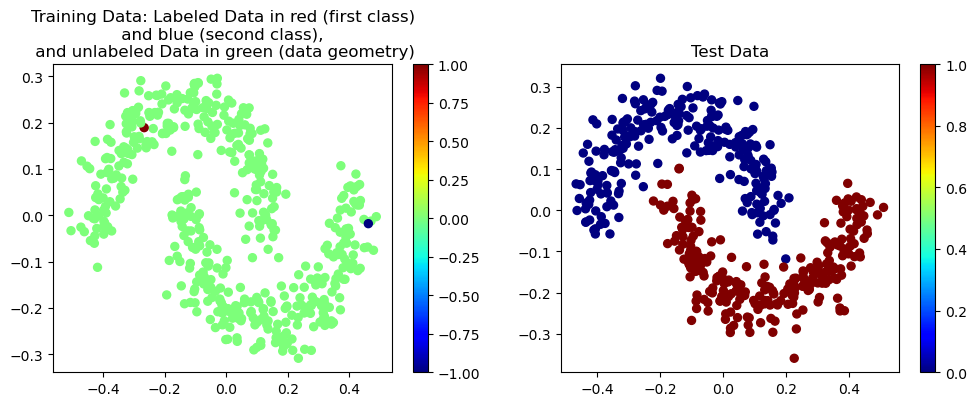

In [3]:
# Plot
plt.figure(figsize=(12,4))
p1 = plt.subplot(121)
size_vertex_plot = 33
plt.scatter(Xtrain[:,0], Xtrain[:,1], s=size_vertex_plot*np.ones(n), c=l_train, color=pyplot.jet())
plt.title('Training Data: Labeled Data in red (first class)\n and blue (second class), \n and unlabeled Data in green (data geometry)')
plt.colorbar()
p2 = plt.subplot(122)
size_vertex_plot = 33
plt.scatter(Xtest[:,0], Xtest[:,1], s=size_vertex_plot*np.ones(n), c=Cgt_test, color=pyplot.jet())
plt.title('Test Data')
plt.colorbar()
#plt.tight_layout()
plt.show()


# Run kernel SVM

### Observe the solution provided by kernel SVM with a limited number of 2 labels

What was the accuracy when using a larger number of labels, i.e. code03? 

Answer: 


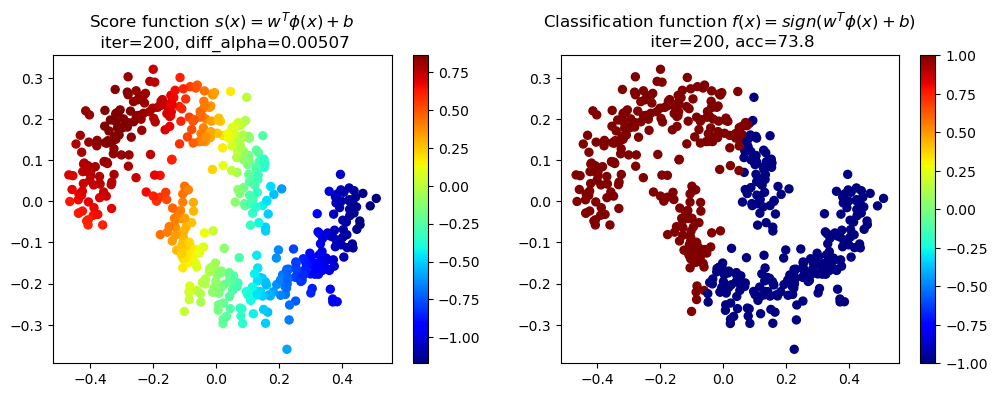

In [4]:
# Run kernel SVM

# Compute Gaussian kernel, L, Q
sigma = 0.5; sigma2 = sigma**2
Ddist = sklearn.metrics.pairwise.pairwise_distances(Xtrain, Xtrain, metric='euclidean', n_jobs=1)
Ker = np.exp(- Ddist**2 / sigma2)
Ddist = sklearn.metrics.pairwise.pairwise_distances(Xtrain, Xtest, metric='euclidean', n_jobs=1)
KXtest = np.exp(- Ddist**2 / sigma2)
l = l_train
L = np.diag(l)
Q = L.dot(Ker.dot(L))

# Time steps
tau_alpha = 10/ np.linalg.norm(Q,2)
tau_beta = 0.1/ np.linalg.norm(L,2)

# For conjuguate gradient
Acg = tau_alpha* Q + np.eye(n)

# Pre-compute J.K(Xtest) for test data
LKXtest = L.dot(KXtest)

# Error parameter
lamb = 3 

# Initialization
alpha = np.zeros([n])
beta = np.zeros([n])
alpha_old = alpha

# Loop
k = 0
diff_alpha = 1e6
num_iter = 201
while (diff_alpha>1e-3) & (k<num_iter):
    
    # Update iteration
    k += 1
    
    # Update alpha
    # Approximate solution with conjuguate gradient
    b0 = alpha + tau_alpha - tau_alpha* l* beta
    alpha, _ = scipy.sparse.linalg.cg(Acg, b0, x0=alpha, tol=1e-3, maxiter=50)   
    alpha[alpha<0.0] = 0 # Projection on [0,+infty]
    alpha[alpha>lamb] = lamb # Projection on [-infty,lamb]

    # Update beta
    beta = beta + tau_beta* l.T.dot(alpha)
    
    # Stopping condition
    diff_alpha = np.linalg.norm(alpha-alpha_old)
    alpha_old = alpha
    
    # Plot
    if not(k%100) or (diff_alpha<1e-3):
           
        # Indicator function of support vectors
        idx = np.where( np.abs(alpha)>0.25* np.max(np.abs(alpha)) )
        Isv = np.zeros([n]); Isv[idx] = 1
        nb_sv = len(Isv.nonzero()[0])
        
        # Offset
        if nb_sv > 1:
            b = (Isv.T).dot( l - Ker.dot(L.dot(alpha)) )/ nb_sv
        else:
            b = 0
            
        # Continuous score function
        f_test = alpha.T.dot(LKXtest) + b 

        # Binary classification function
        C_test = np.sign(f_test) # decision function in {-1,1}
        accuracy_test = compute_purity(0.5*(1+C_test),Cgt_test,nc) # 0.5*(1+C_test) in {0,1}

        # Plot
        size_vertex_plot = 33
        plt.figure(figsize=(12,4))
        p1 = plt.subplot(121)
        plt.scatter(Xtest[:,0], Xtest[:,1], s=size_vertex_plot*np.ones(n), c=f_test, color=pyplot.jet())
        plt.title('Score function $s(x)=w^T\phi(x)+b$ \n iter=' + str(k)+ ', diff_alpha=' + str(diff_alpha)[:7])
        plt.colorbar()
        p2 = plt.subplot(122)
        plt.scatter(Xtest[:,0], Xtest[:,1], s=size_vertex_plot*np.ones(n), c=C_test, color=pyplot.jet())
        plt.title('Classification function $f(x)=sign(w^T\phi(x)+b)$\n iter=' + str(k) + ', acc=' + str(accuracy_test)[:5])
        #plt.tight_layout()
        plt.colorbar()
        plt.show()
        if k<num_iter-1:
            clear_output(wait=True)   
        


# Run Graph SVM

In [5]:
# Compute Gaussian kernel 
sigma = 0.15; sigma2 = sigma**2
Ddist = sklearn.metrics.pairwise.pairwise_distances(Xtrain, Xtrain, metric='euclidean', n_jobs=1)
Ker = np.exp(- Ddist**2 / sigma2)
Ddist = sklearn.metrics.pairwise.pairwise_distances(Xtrain, Xtest, metric='euclidean', n_jobs=1)
KXtest = np.exp(- Ddist**2 / sigma2)


### Question 1 : Construct a KNN graph from training data and compute the Laplacian matrix

You may use `A = construct_knn_graph(data, k, dist_metric)` to generate the adjacency matrix of a KNN graph from a training dataset.

Usage:
- `data`: The features of the training data.
- `k`: The number of nearest neighbors.
- `dist_metric`: The distance matric, e.g., using the Euclidean distance `'euclidean'`, `'euclidean_zelnik_perona'` or `'cosine'`.
- `A`: The adjacency matrix of the KNN graph.

You may consider `Lap = graph_laplacian(A).todense()` to obtain the Laplacian matrix from an adjacency matrix `A`.


In [7]:
# Compute kNN graph
############################################################################
# Your code start
############################################################################

kNN = 10
A = construct_knn_graph(Xtrain, kNN, 'euclidean')
Lap = graph_laplacian(A).todense()

############################################################################
# Your code end
############################################################################


k-NN graph with euclidean distance


### Question 3: Compute the indicator function of labels


In [12]:
# Compute Indicator function of labels
############################################################################
# Your code start
############################################################################

#This code constructs a diagonal indicator matrix 
#H that marks which training samples are labeled

H = np.zeros([n])
# Sets entries to 1 where the corresponding label in l_train is nonzero 
# (i.e., the sample is labeled). Unlabeled samples (label 0) remain 0.
H[np.abs(l_train)>0.0] = 1
# Converts the indicator vector into a diagonal matrix. The diagonal entry 
# H[i,i] is 1 if sample i is labeled, 0 if unlabeled.
H = np.diag(H)
print(H)

############################################################################
# Your code end
############################################################################


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


### Question 4: Compute L, Q for graph SVM

Refer to Lecture 4 Page 50:

- $L = \text{Diag}(l)$
- $Q = LHK(I+\gamma \mathcal{L}K)^{-1}HL$

You may use these functions:
* `np.diag()`: Diagonal matrix from a vector.
* `np.eye()`: Identity matrix.
* `np.linalg.inv()`: Inverse matrix.


In [15]:
# Compute L, Q
############################################################################
# Your code start
############################################################################

gamma = 25 # weight of the graph loss
l = l_train
L = np.diag(l)
T = np.eye(n) + gamma * Lap @ Ker
Tinv = np.linalg.inv(T)
Q = L @ H @ Ker @ Tinv @ H @ L

############################################################################
# Your code end
############################################################################


C_test (500,)


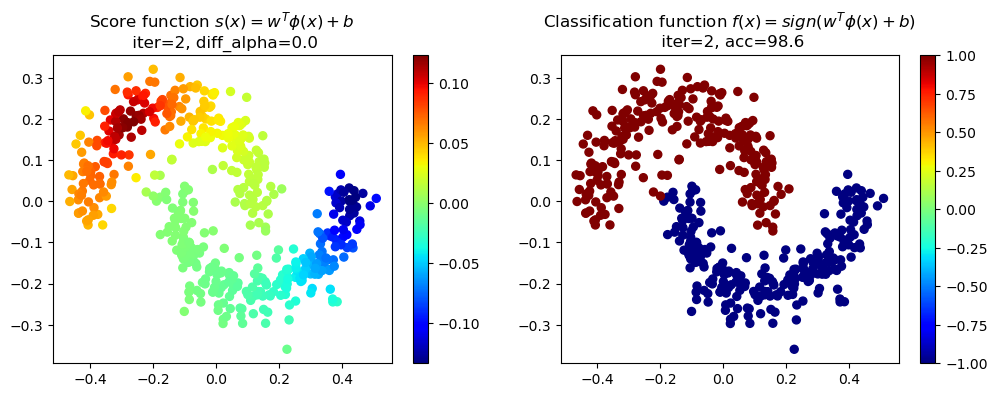

In [16]:
# Run Graph SVM

# Time steps
tau_alpha = 1/ np.linalg.norm(Q,2)
tau_beta = 1/ np.linalg.norm(L,2)

# For conjuguate gradient
Acg = tau_alpha* Q + np.eye(n)

# Error parameter
lamb = 1 

# Initialization
alpha = np.zeros([n])
beta = np.zeros([n])
alpha_old = alpha

# Loop
k = 0
diff_alpha = 1e6
num_iter = 201
while (diff_alpha>1e-3) & (k<num_iter):
    
    # Update iteration
    k += 1
    
    # Update alpha
    # Approximate solution with conjuguate gradient
    b0 = alpha + tau_alpha - tau_alpha* l* beta
    alpha, _ = scipy.sparse.linalg.cg(Acg, b0, x0=alpha, tol=1e-3, maxiter=50)   
    alpha[alpha<0.0] = 0 # Projection on [0,+infty]
    alpha[alpha>lamb] = lamb # Projection on [-infty,lamb]

    # Update beta
    beta = beta + tau_beta* l.T.dot(alpha)
    
    # Stopping condition
    diff_alpha = np.linalg.norm(alpha-alpha_old)
    alpha_old = alpha
    
    # Plot
    if not(k%100) or (diff_alpha<1e-3):
        
        # xi vector
        xi = Tinv.dot(H.dot(L.dot(alpha)))

        # Offset
        idx_unlabeled_data = np.where( np.abs(l)<1./2 )
        alpha_labels = alpha; alpha_labels[idx_unlabeled_data] = 0
        idx = np.where( np.abs(alpha_labels)>0.25* np.max(np.abs(alpha_labels)) )
        Isv = np.zeros([n]); Isv[idx] = 1 # Indicator function of Support Vectors
        nb_sv = len(Isv.nonzero()[0])
        if nb_sv > 1:
            b = (Isv.T).dot( l - Ker.dot(np.squeeze(np.array(xi))) )/ nb_sv
        else:
            b = 0        
            
        # Continuous score function
        f_test = np.squeeze(np.array(xi.dot(KXtest) + b))

        # Binary classification function
        C_test = np.sign(f_test) # decision function in {-1,1}
        print('C_test',C_test.shape)
        accuracy_test = compute_purity(0.5*(1+C_test),Cgt_test,nc) # 0.5*(1+C_test) in {0,1}

        # Plot
        size_vertex_plot = 33
        plt.figure(figsize=(12,4))
        p1 = plt.subplot(121)
        plt.scatter(Xtest[:,0], Xtest[:,1], s=size_vertex_plot*np.ones(n), c=f_test, color=pyplot.jet())
        plt.title('Score function $s(x)=w^T\phi(x)+b$ \n iter=' + str(k)+ ', diff_alpha=' + str(diff_alpha)[:7])
        plt.colorbar()
        p2 = plt.subplot(122)
        plt.scatter(Xtest[:,0], Xtest[:,1], s=size_vertex_plot*np.ones(n), c=C_test, color=pyplot.jet())
        plt.title('Classification function $f(x)=sign(w^T\phi(x)+b)$\n iter=' + str(k) + ', acc=' + str(accuracy_test)[:5])
        #plt.tight_layout()
        plt.colorbar()
        plt.show()
        if k<num_iter-1:
            clear_output(wait=True)   
        

# Real-world graph of articles

# Dataset has 10 labeled data and 40 unlabeled data

In [17]:
# Dataset
mat = scipy.io.loadmat('datasets/data_20news_10labels_40unlabels.mat')
Xtrain = mat['Xtrain']
n = Xtrain.shape[0]
l_train = mat['l'].squeeze()
d = Xtrain.shape[1]
Xtest = mat['Xtest']
Cgt_test = mat['Cgt_test'] - 1; Cgt_test = Cgt_test.squeeze()
nc = len(np.unique(Cgt_test))
print(n,d,nc)
num_labels = np.sum(np.abs(l_train)>0.0)
print('l_train:',l_train)
print('number of labeled data per class:',num_labels//2)
print('number of unlabeled data:',n-num_labels)


50 3684 2
l_train: [-1  0 -1 -1 -1  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  1  0  0  0  0  0  0  1  0  0  0  0 -1  0  0  0  0  0  0  1
  1  0]
number of labeled data per class: 5
number of unlabeled data: 40


# Run Kernel SVM (no graph information)

In [18]:
# Run Kernel SVM (no graph information)

# Compute Gaussian kernel 
sigma = 0.5; sigma2 = sigma**2
Ddist = sklearn.metrics.pairwise.pairwise_distances(Xtrain, Xtrain, metric='euclidean', n_jobs=1)
Ker = np.exp(- Ddist**2 / sigma2)
Ddist = sklearn.metrics.pairwise.pairwise_distances(Xtrain, Xtest, metric='euclidean', n_jobs=1)
KXtest = np.exp(- Ddist**2 / sigma2)

# Compute kNN graph
kNN = 5
gamma = 0 # <= no graph information
A = construct_knn_graph(Xtrain, kNN, 'cosine')
Lap = graph_laplacian(A).todense()

# Compute Indicator function of labels
H = np.zeros([n])
H[np.abs(l_train)>0.0] = 1
H = np.diag(H)

# Compute L, Q
L = np.diag(l_train)
l = l_train
T = np.eye(n)
T += gamma* Lap.dot(Ker) 
Tinv = np.linalg.inv(T)
Q = L.dot(H.dot(Ker.dot(Tinv.dot(H.dot(L)))))

# Time steps
tau_alpha = 1/ np.linalg.norm(Q,2)
tau_beta = 1/ np.linalg.norm(L,2)

# For conjuguate gradient
Acg = tau_alpha* Q + 1* np.eye(n)

# Error parameter
lamb = 100 

# Initialization
alpha = np.zeros([n])
beta = np.zeros([n])
alpha_old = alpha

# Loop
k = 0
diff_alpha = 1e6
num_iter = 1001
while (diff_alpha>1e-3) & (k<num_iter):
    
    # Update iteration
    k += 1
    
    # Update alpha
    # Approximate solution with conjuguate gradient
    b0 = alpha + tau_alpha - tau_alpha* l* beta
    alpha, _ = scipy.sparse.linalg.cg(Acg, b0, x0=alpha, tol=1e-3, maxiter=50)   
    alpha[alpha<0.0] = 0 # Projection on [0,+infty]
    alpha[alpha>lamb] = lamb # Projection on [-infty,lamb]

    # Update beta
    beta = beta + tau_beta* l.T.dot(alpha)
    
    # Stopping condition
    diff_alpha = np.linalg.norm(alpha-alpha_old)
    alpha_old = alpha
    
    # Plot
    if not(k%100) or (diff_alpha<1e-3):
        
        # xi vector
        xi = Tinv.dot(H.dot(L.dot(alpha)))

        # Offset
        idx_unlabeled_data = np.where( np.abs(l)<1./2 )
        alpha_labels = alpha; alpha_labels[idx_unlabeled_data] = 0
        idx = np.where( np.abs(alpha_labels)>0.25* np.max(np.abs(alpha_labels)) )
        Isv = np.zeros([n]); Isv[idx] = 1 # Indicator function of Support Vectors
        nb_sv = len(Isv.nonzero()[0])
        if nb_sv > 1:
            b = (Isv.T).dot( l - Ker.dot(np.squeeze(np.array(xi))) )/ nb_sv
        else:
            b = 0        
            
        # Continuous score function
        f_test = xi.dot(KXtest) + b

        # Binary classification function
        C_test = np.sign(f_test) # decision function in {-1,1}
        accuracy_test = compute_purity(0.5*(1+C_test),Cgt_test,nc) # 0.5*(1+C_test) in {0,1}

        # Print
        # print('iter, diff_alpha',str(k),str(diff_alpha)[:7])
        # print('acc',str(accuracy_test)[:5])

print('Kernel SVM  iter, diff_alpha :',str(k),str(diff_alpha)[:7])
print('            acc :',str(accuracy_test)[:5])


k-NN graph with cosine distance
Kernel SVM  iter, diff_alpha : 1001 0.68597
            acc : 65.5


# Run Graph SVM

### Question 5: Compare the results with kernel SVM and deduce the implications of graph SVM outperforming kernel SVM on real-world data?

Answer: 


In [19]:
# Run Graph SVM

# Compute Gaussian kernel 
sigma = 0.5; sigma2 = sigma**2
Ddist = sklearn.metrics.pairwise.pairwise_distances(Xtrain, Xtrain, metric='euclidean', n_jobs=1)
Ker = np.exp(- Ddist**2 / sigma2)
Ddist = sklearn.metrics.pairwise.pairwise_distances(Xtrain, Xtest, metric='euclidean', n_jobs=1)
KXtest = np.exp(- Ddist**2 / sigma2)

# Compute kNN graph
kNN = 8
gamma = 100
A = construct_knn_graph(Xtrain, kNN, 'cosine')
Lap = graph_laplacian(A).todense()

# Compute Indicator function of labels
H = np.zeros([n])
H[np.abs(l_train)>0.0] = 1
H = np.diag(H)

# Compute L, Q
L = np.diag(l_train)
l = l_train
T = np.eye(n)
T += gamma* Lap.dot(Ker) 
Tinv = np.linalg.inv(T)
Q = L.dot(H.dot(Ker.dot(Tinv.dot(H.dot(L)))))

# Time steps
tau_alpha = 1/ np.linalg.norm(Q,2)
tau_beta = 1/ np.linalg.norm(L,2)

# For conjuguate gradient
Acg = tau_alpha* Q + 1* np.eye(n)

# Error parameter
lamb = 1

# Initialization
alpha = np.zeros([n])
beta = np.zeros([n])
alpha_old = alpha

# Loop
k = 0
diff_alpha = 1e6
num_iter = 1001
while (diff_alpha>1e-3) & (k<num_iter):
    
    # Update iteration
    k += 1
    
    # Update alpha
    # Approximate solution with conjuguate gradient
    b0 = alpha + tau_alpha - tau_alpha* l* beta
    alpha, _ = scipy.sparse.linalg.cg(Acg, b0, x0=alpha, tol=1e-3, maxiter=50)   
    alpha[alpha<0.0] = 0 # Projection on [0,+infty]
    alpha[alpha>lamb] = lamb # Projection on [-infty,lamb]

    # Update beta
    beta = beta + tau_beta* l.T.dot(alpha)
    
    # Stopping condition
    diff_alpha = np.linalg.norm(alpha-alpha_old)
    alpha_old = alpha
    
    # Plot
    if not(k%100) or (diff_alpha<1e-3):
        
        # xi vector
        xi = Tinv.dot(H.dot(L.dot(alpha)))

        # Offset
        idx_unlabeled_data = np.where( np.abs(l)<1./2 )
        alpha_labels = alpha; alpha_labels[idx_unlabeled_data] = 0
        idx = np.where( np.abs(alpha_labels)>0.25* np.max(np.abs(alpha_labels)) )
        Isv = np.zeros([n]); Isv[idx] = 1 # Indicator function of Support Vectors
        nb_sv = len(Isv.nonzero()[0])
        if nb_sv > 1:
            b = (Isv.T).dot( l - Ker.dot(np.squeeze(np.array(xi))) )/ nb_sv
        else:
            b = 0        
            
        # Continuous score function
        f_test = xi.dot(KXtest) + b

        # Binary classification function
        C_test = np.sign(f_test) # decision function in {-1,1}
        accuracy_test = compute_purity(0.5*(1+C_test),Cgt_test,nc) # 0.5*(1+C_test) in {0,1}

        # Print
        # print('iter, diff_alpha',str(k),str(diff_alpha)[:7])
        # print('acc',str(accuracy_test)[:5])

print('Graph SVM  iter, diff_alpha :',str(k),str(diff_alpha)[:7])
print('           acc :',str(accuracy_test)[:5])


k-NN graph with cosine distance
Graph SVM  iter, diff_alpha : 2 0.0
           acc : 78.5


# Plot graph of test data points

k-NN graph with cosine distance
<class 'scipy.sparse._csr.csr_matrix'> (200, 200)


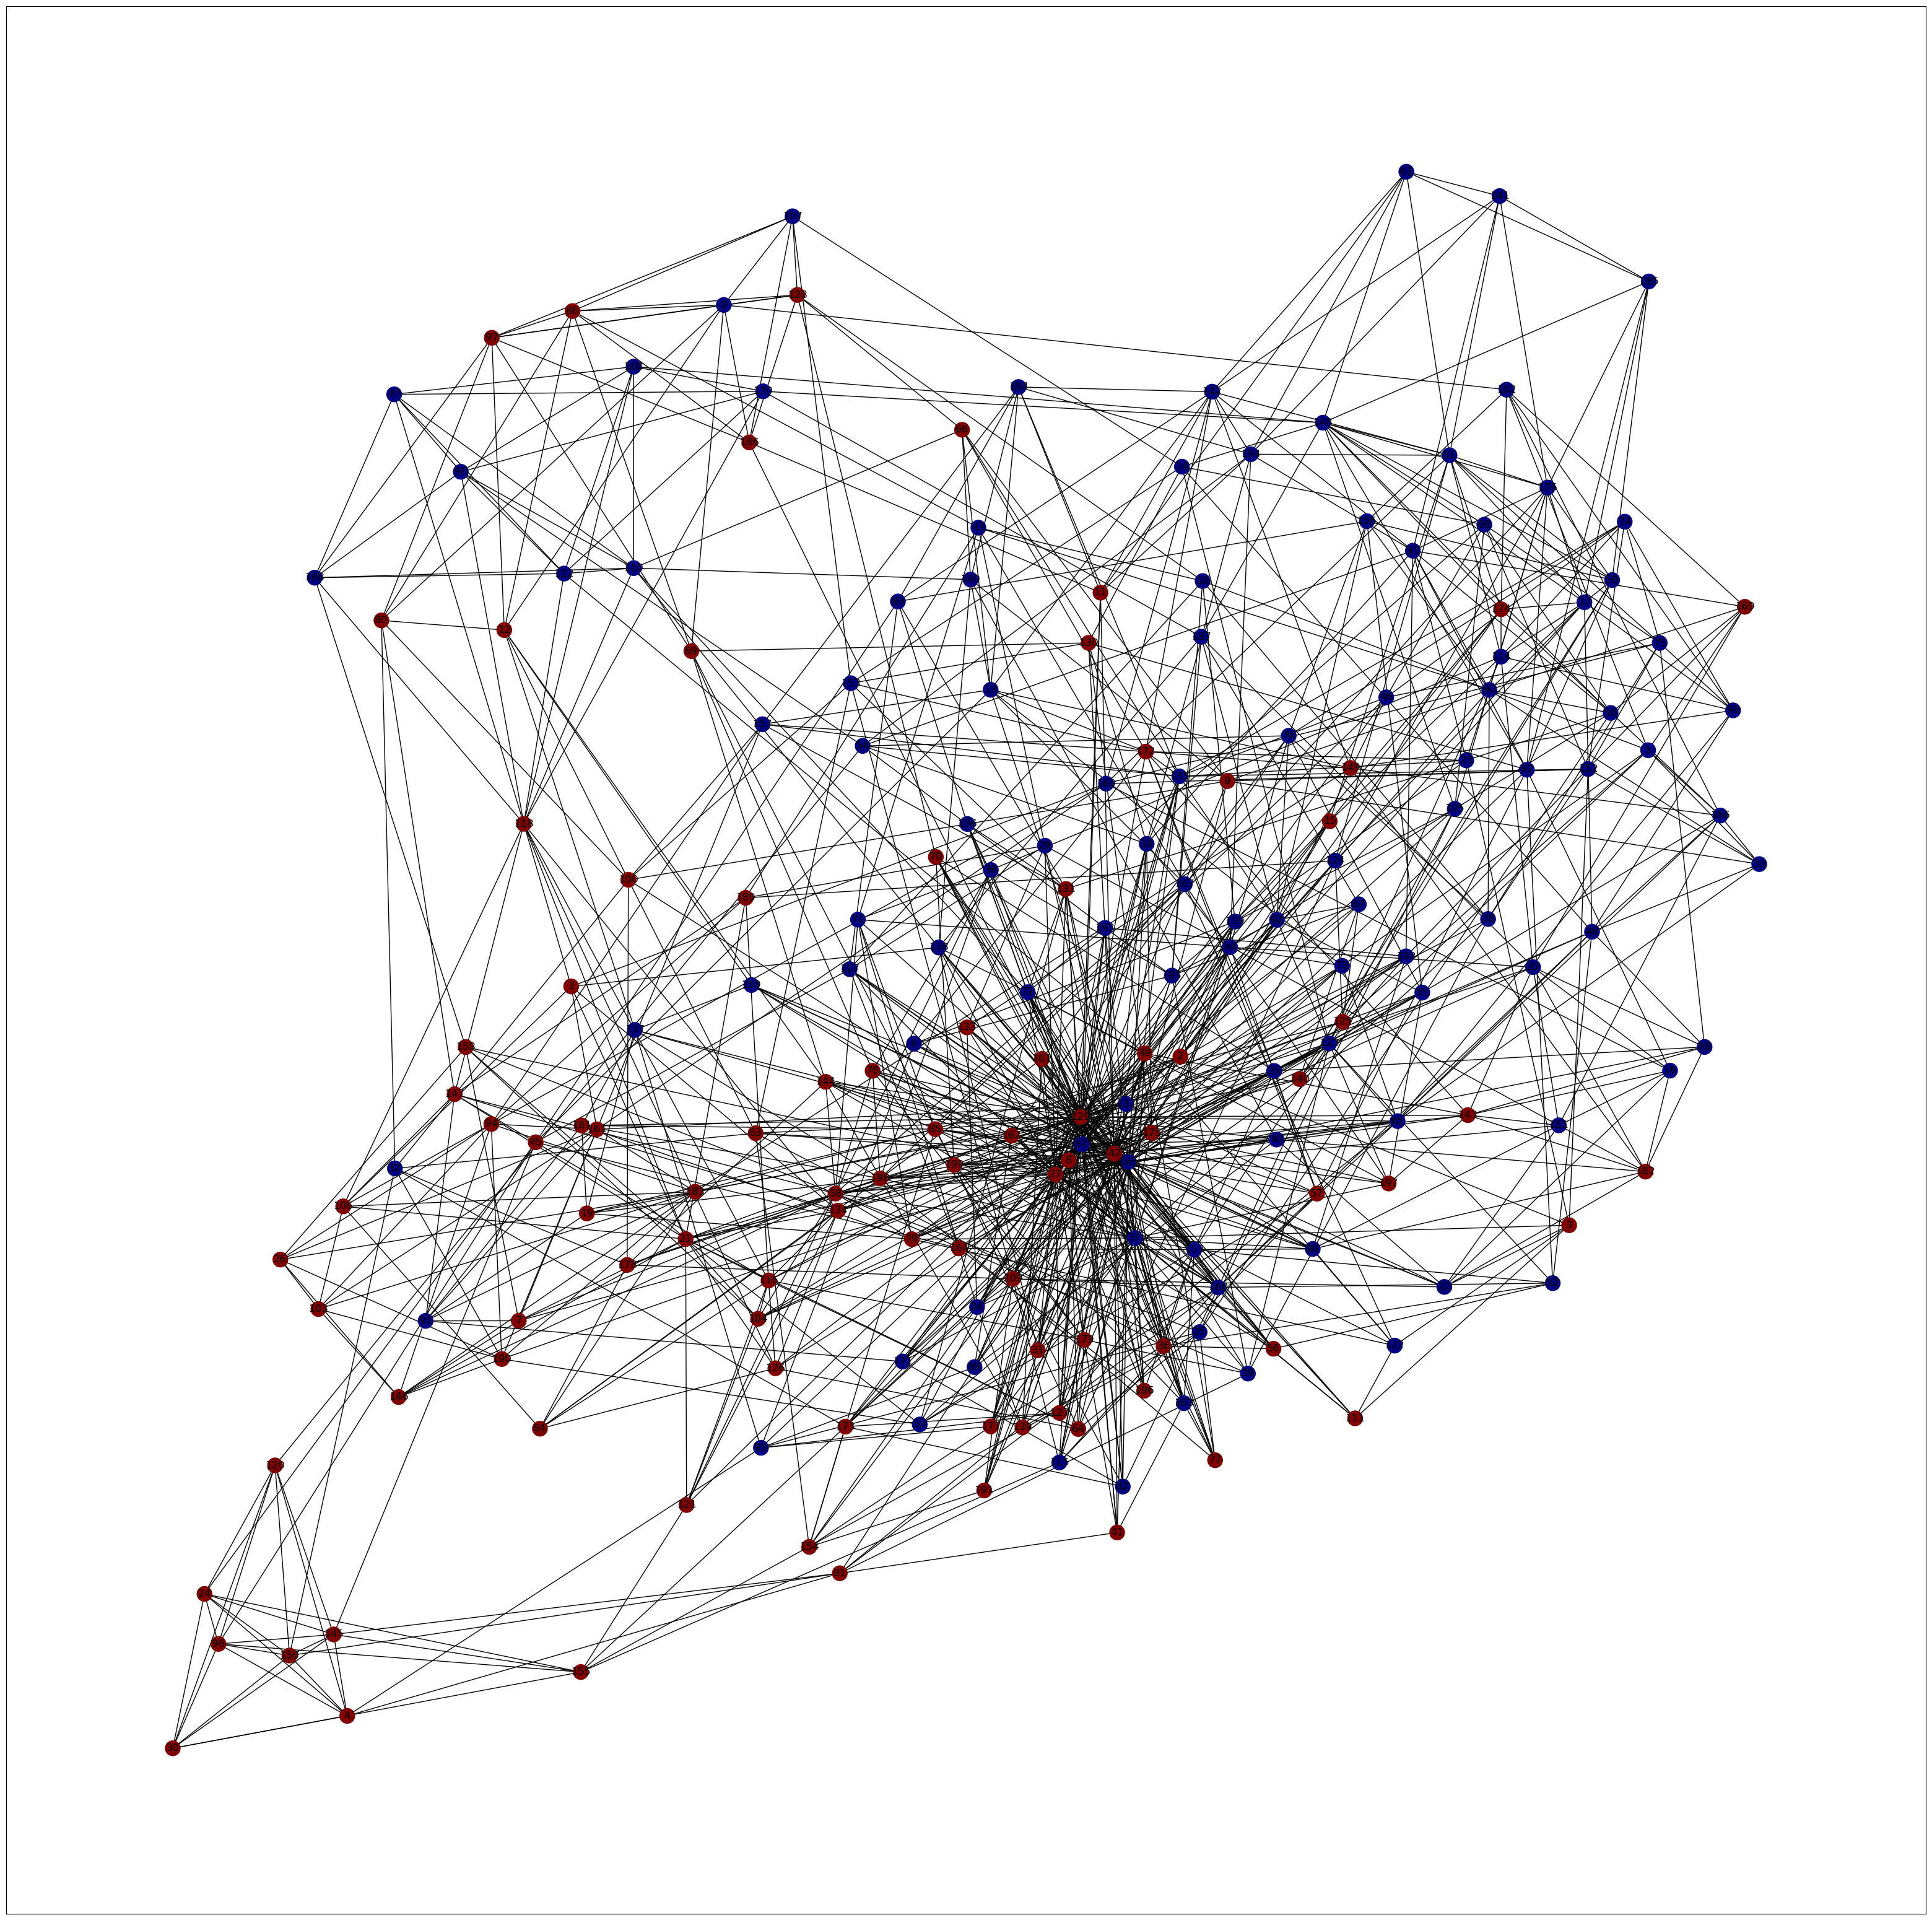

: 

In [ ]:
# Plot graph of test data points
kNN = 8 
A = construct_knn_graph(Xtest, kNN, 'cosine')
print(type(A),A.shape)

import networkx as nx
A.setdiag(0) 
A.eliminate_zeros()
G_nx = nx.from_scipy_sparse_array(A)
plt.figure(figsize=[40,40])
nx.draw_networkx(G_nx, with_labels=True, node_color=np.array(C_test), cmap='jet')
